# 4-2_（演習）決定木によるガンの悪性腫瘍の分類
こちらはロジスティック回帰で扱っているガンの悪性腫瘍判定と学習を開始するまで同じプログラムになっています。（決定木のライブラリや可視化のためのライブラリインポートは除く）

※ ただし、決定木系のアルゴリズムではスケールをそろえる必要がないため、ロジスティック回帰モデルで精度改善のために行っていた標準化は行いません。

## ライブラリのインポート

In [1]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# 決定木モデルをインポート
from sklearn.tree import DecisionTreeClassifier
# 決定木を可視化したい場合はplot_treeもインポートする
from sklearn.tree import plot_tree

In [3]:
# matplotlibで日本語表示するための設定
!pip install japanize_matplotlib | tail -n 1
import japanize_matplotlib

Google Colaboratory上での出力のデフォルト設定

In [4]:
# pandasのDataframeの出力
pd.set_option('display.max_columns', 500) # 表示列の最大
pd.set_option('display.max_rows', 500) # 表示行の最大
pd.set_option('display.unicode.east_asian_width', True) # 日本語出力時にヘッダのずれを解消
pd.options.display.float_format = '{:,.5f}'.format # 表示桁数の設定

# ノートブックの表示桁数設定。この設定はprint文には作用せず、セルの最後に書いたものを出力する際に適用されます。
%precision 3
# numpy配列の指数表示禁止設定
np.set_printoptions(suppress=True)
# numpy配列の表示桁数設定
np.set_printoptions(precision=3)

## データの準備
今回使用するデータはscikit-learnからもデータセットとして利用することができる、UCI ML Breast Cancer Wisconsin (Diagnostic) datasetsのコピーです。<br>
UCI Machine Learning Repositoryから公開されています。<br>
downloaded from : https://goo.gl/U2Uwz2

データセットについての説明はこちらに記載されています。<br>
https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

#### データを取り込む
- pandasのread_csvメソッドを使用して、mlho/data/cancer.csvファイルを読み込みます
- 読み込んだものは変数df_cancerに代入します

In [5]:
# csvファイルを読み込みます
df_cancer = pd.read_csv("/content/drive/MyDrive/mlho/data/cancer.csv")

#### データを確認する

In [6]:
# 読み込んだデータを確認します
# Classが目的変数になる腫瘍の悪性または良性を表しています。（0:悪性、1:良性）
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Class
0,17.99000,10.38000,122.80000,"1,001.00000",0.11840,0.27760,0.30010,0.14710,0.24190,0.07871,1.09500,0.90530,8.58900,153.40000,0.00640,0.04904,0.05373,0.01587,0.03003,0.00619,25.38000,17.33000,184.60000,"2,019.00000",0.16220,0.66560,0.71190,0.26540,0.46010,0.11890,0
1,20.57000,17.77000,132.90000,"1,326.00000",0.08474,0.07864,0.08690,0.07017,0.18120,0.05667,0.54350,0.73390,3.39800,74.08000,0.00522,0.01308,0.01860,0.01340,0.01389,0.00353,24.99000,23.41000,158.80000,"1,956.00000",0.12380,0.18660,0.24160,0.18600,0.27500,0.08902,0
2,19.69000,21.25000,130.00000,"1,203.00000",0.10960,0.15990,0.19740,0.12790,0.20690,0.05999,0.74560,0.78690,4.58500,94.03000,0.00615,0.04006,0.03832,0.02058,0.02250,0.00457,23.57000,25.53000,152.50000,"1,709.00000",0.14440,0.42450,0.45040,0.24300,0.36130,0.08758,0
3,11.42000,20.38000,77.58000,386.10000,0.14250,0.28390,0.24140,0.10520,0.25970,0.09744,0.49560,1.15600,3.44500,27.23000,0.00911,0.07458,0.05661,0.01867,0.05963,0.00921,14.91000,26.50000,98.87000,567.70000,0.20980,0.86630,0.68690,0.25750,0.66380,0.17300,0
4,20.29000,14.34000,135.10000,"1,297.00000",0.10030,0.13280,0.19800,0.10430,0.18090,0.05883,0.75720,0.78130,5.43800,94.44000,0.01149,0.02461,0.05688,0.01885,0.01756,0.00511,22.54000,16.67000,152.20000,"1,575.00000",0.13740,0.20500,0.40000,0.16250,0.23640,0.07678,0


In [7]:
# df_cancerのデータ要約を確認
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [8]:
# df_cancerの統計情報を確認
df_cancer.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Class
count,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000,569.00000
mean,14.12729,19.28965,91.96903,654.88910,0.09636,0.10434,0.08880,0.04892,0.18116,0.06280,0.40517,1.21685,2.86606,40.33708,0.00704,0.02548,0.03189,0.01180,0.02054,0.00379,16.26919,25.67722,107.26121,880.58313,0.13237,0.25427,0.27219,0.11461,0.29008,0.08395,0.62742
std,3.52405,4.30104,24.29898,351.91413,0.01406,0.05281,0.07972,0.03880,0.02741,0.00706,0.27731,0.55165,2.02185,45.49101,0.00300,0.01791,0.03019,0.00617,0.00827,0.00265,4.83324,6.14626,33.60254,569.35699,0.02283,0.15734,0.20862,0.06573,0.06187,0.01806,0.48392
min,6.98100,9.71000,43.79000,143.50000,0.05263,0.01938,0.00000,0.00000,0.10600,0.04996,0.11150,0.36020,0.75700,6.80200,0.00171,0.00225,0.00000,0.00000,0.00788,0.00089,7.93000,12.02000,50.41000,185.20000,0.07117,0.02729,0.00000,0.00000,0.15650,0.05504,0.00000
25%,11.70000,16.17000,75.17000,420.30000,0.08637,0.06492,0.02956,0.02031,0.16190,0.05770,0.23240,0.83390,1.60600,17.85000,0.00517,0.01308,0.01509,0.00764,0.01516,0.00225,13.01000,21.08000,84.11000,515.30000,0.11660,0.14720,0.11450,0.06493,0.25040,0.07146,0.00000
50%,13.37000,18.84000,86.24000,551.10000,0.09587,0.09263,0.06154,0.03350,0.17920,0.06154,0.32420,1.10800,2.28700,24.53000,0.00638,0.02045,0.02589,0.01093,0.01873,0.00319,14.97000,25.41000,97.66000,686.50000,0.13130,0.21190,0.22670,0.09993,0.28220,0.08004,1.00000
75%,15.78000,21.80000,104.10000,782.70000,0.10530,0.13040,0.13070,0.07400,0.19570,0.06612,0.47890,1.47400,3.35700,45.19000,0.00815,0.03245,0.04205,0.01471,0.02348,0.00456,18.79000,29.72000,125.40000,"1,084.00000",0.14600,0.33910,0.38290,0.16140,0.31790,0.09208,1.00000
max,28.11000,39.28000,188.50000,"2,501.00000",0.16340,0.34540,0.42680,0.20120,0.30400,0.09744,2.87300,4.88500,21.98000,542.20000,0.03113,0.13540,0.39600,0.05279,0.07895,0.02984,36.04000,49.54000,251.20000,"4,254.00000",0.22260,1.05800,1.25200,0.29100,0.66380,0.20750,1.00000


#### 説明変数、目的変数を切り出す

In [9]:
# 目的変数にするClass以外をすべて説明変数にする
x = df_cancer.drop(columns='Class')

In [10]:
x.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99000,10.38000,122.80000,"1,001.00000",0.11840,0.27760,0.30010,0.14710,0.24190,0.07871,1.09500,0.90530,8.58900,153.40000,0.00640,0.04904,0.05373,0.01587,0.03003,0.00619,25.38000,17.33000,184.60000,"2,019.00000",0.16220,0.66560,0.71190,0.26540,0.46010,0.11890
1,20.57000,17.77000,132.90000,"1,326.00000",0.08474,0.07864,0.08690,0.07017,0.18120,0.05667,0.54350,0.73390,3.39800,74.08000,0.00522,0.01308,0.01860,0.01340,0.01389,0.00353,24.99000,23.41000,158.80000,"1,956.00000",0.12380,0.18660,0.24160,0.18600,0.27500,0.08902


In [11]:
y = df_cancer['Class']

In [12]:
y.head(2)

0    0
1    0
Name: Class, dtype: int64

#### データを訓練データと検証データに分割する

**本研修でbreast-cancerデータセットを使用する際には、訓練データ70%、random_state=3で固定しています。他のモデルとの比較をしやすくするためです**

In [13]:
# 訓練データと検証データに分割(70%を訓練用に使用)
# stratifyは指定した列の値が均等に割り振られる
train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=3, stratify=y)

## モデルの定義

In [14]:
model = DecisionTreeClassifier(random_state=0)

## モデルの学習

In [15]:
model.fit(train_x, train_y)

DecisionTreeClassifier(random_state=0)

## 作成された決定木を可視化する

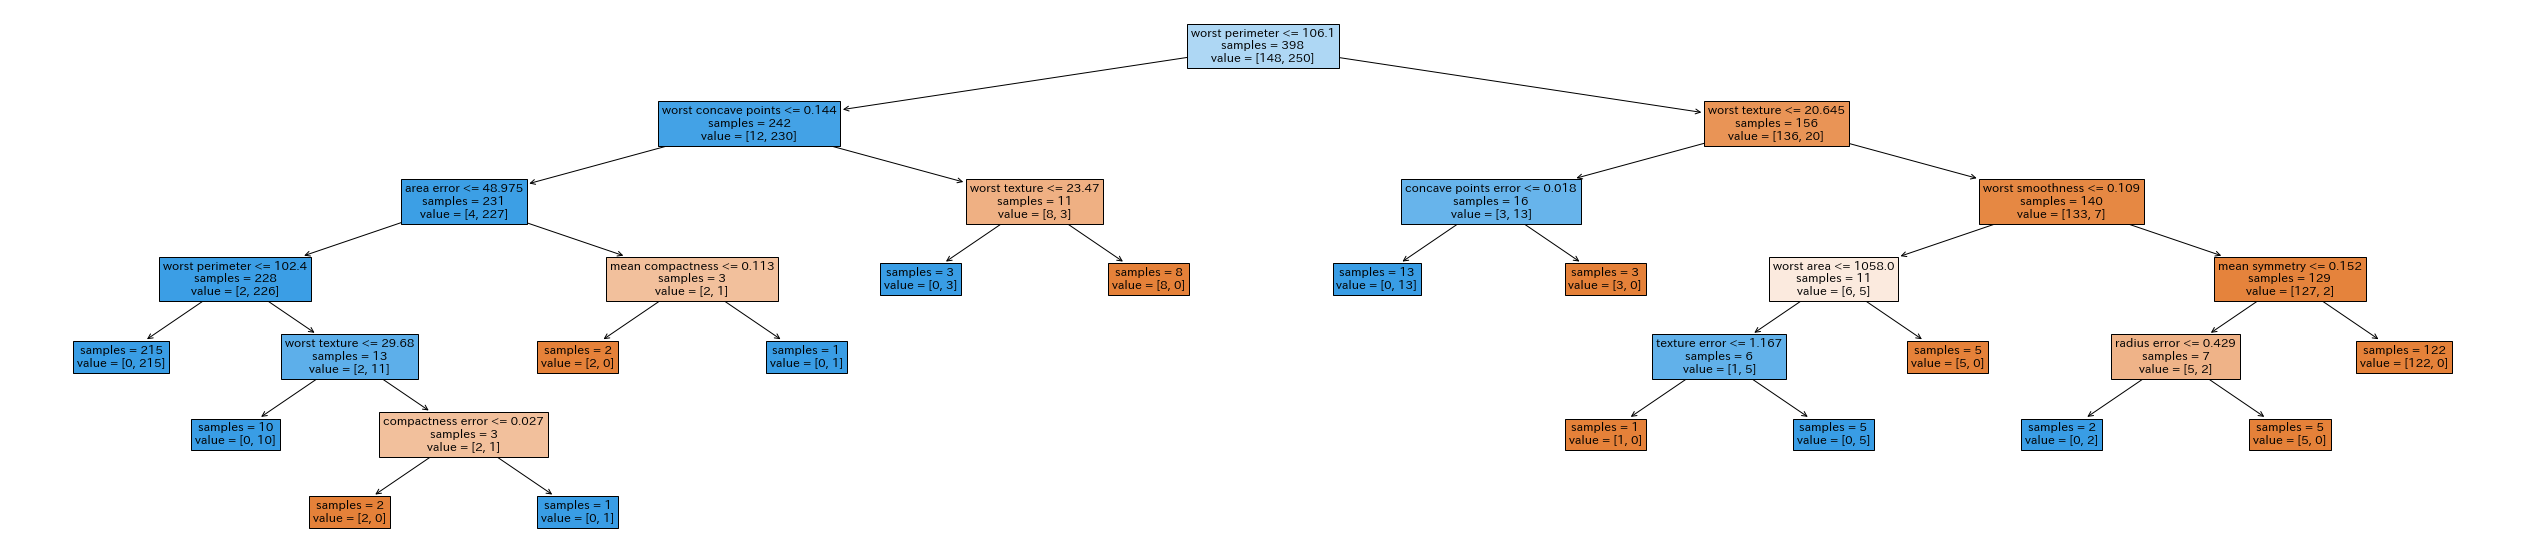

In [16]:
# 決定木の可視化を行う
# matplotlibで画像サイズの調整（横幅、縦幅）
plt.figure(figsize=(45,10))
# 描画と設定
plot_tree(
    model, # 可視化するモデルを指定
    max_depth=6, # 可視化する木の深さ
    feature_names = train_x.columns, # 分割するときの説明変数名を設定
    filled=True, # 色を付ける場合はTrue
    fontsize=12,
    impurity=False
    )
#matplotlibで保存
plt.savefig("tree.pdf")

## 評価

In [17]:
# 訓練データで予測精度（正解率）を確認する
model.score(train_x, train_y)

1.000

In [18]:
# 検証データで予測精度（正解率）を確認する
model.score(val_x, val_y)

0.906

# 決定木モデルのパラメータチューニング

In [19]:
# ハイパーパラメータを変えて、精度の変化を確認してみましょう
model = DecisionTreeClassifier(max_depth = 15, random_state=0)
model.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=15, random_state=0)

In [20]:
# 訓練データで予測精度（正解率）を確認する
model.score(train_x, train_y)

1.000

In [21]:
# 検証データで予測精度（正解率）を確認する
model.score(val_x, val_y)

0.906

**※ 調整例**

`model = DecisionTreeClassifier(max_depth=4, random_state=0)`

過学習を抑制して93%程の正解率が出ます。

In [22]:
# 検証データのclassification_reportを確認する
prediction = model.predict(val_x)
print(classification_report(val_y, prediction))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        64
           1       0.92      0.93      0.93       107

    accuracy                           0.91       171
   macro avg       0.90      0.90      0.90       171
weighted avg       0.91      0.91      0.91       171



## 特徴量（説明変数）の重要度を確認する

In [23]:
# 特徴量重要度
importances= model.feature_importances_
importances

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.007, 0.   , 0.   , 0.006,
       0.   , 0.015, 0.009, 0.   , 0.014, 0.   , 0.007, 0.   , 0.026,
       0.   , 0.   , 0.   , 0.124, 0.693, 0.02 , 0.021, 0.   , 0.   ,
       0.057, 0.   , 0.   ])

In [24]:
# DataFrameに整形して出力
# dataを特徴量重要度に設定し、行のインデックスを説明変数の列名にする
df_importances =pd.DataFrame(data=importances, index=train_x.columns)
df_importances

,0
mean radius,0.00000
mean texture,0.00000
mean perimeter,0.00000
mean area,0.00000
mean smoothness,0.00000
mean compactness,0.00717
mean concavity,0.00000
mean concave points,0.00000
mean symmetry,0.00581
mean fractal dimension,0.00000


In [25]:
# 特徴量重要度（0番目の列）でソートする。ascending=Falseで降順に並び替える
df_importances.sort_values(0, ascending=False)

,0
worst perimeter,0.69289
worst texture,0.12430
worst concave points,0.05693
concave points error,0.02622
worst smoothness,0.02102
worst area,0.02037
radius error,0.01537
area error,0.01379
texture error,0.00896
mean compactness,0.00717


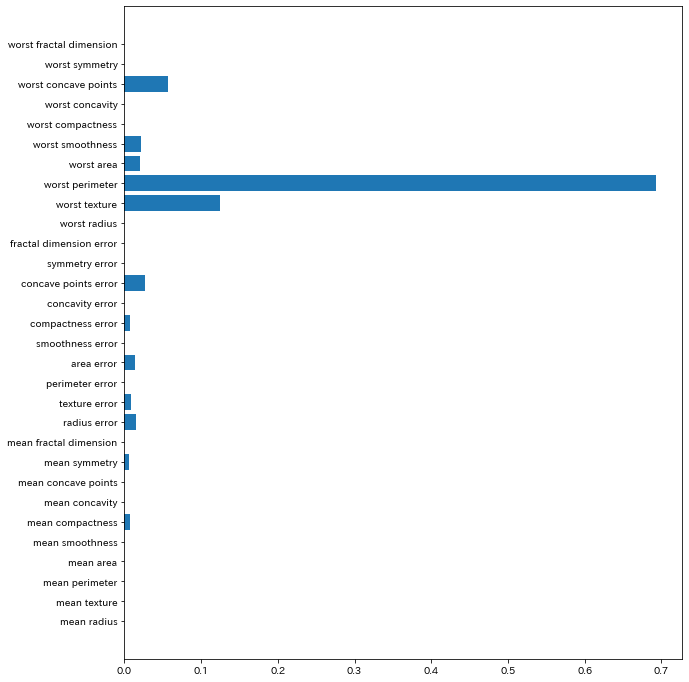

In [26]:
# （参考）matplotlibで棒グラフにする
plt.figure(figsize=(10,12))   # グラフのサイズ
n_features = train_x.shape[1] # 特徴量の数
plt.barh(range(n_features), model.feature_importances_, align='center') # x軸に特徴量、y軸に重要度を表示して中央寄せ（横棒グラフなので、x,yが逆）
plt.yticks(np.arange(n_features), train_x.columns) # x軸に項目名を表示
plt.plot;                     # グラフを表示